In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from util import Logger
import numpy as np
import matplotlib.pyplot as plt

# 1. Reading From Dataset
First and foremost, we need a dataset to train our model. We can easily read the dataset thanks to [Hossein Zaredar](https://github.com/HosseinZaredar/Computational-Intelligence/blob/main/read_MNIST.py)'s help

In [2]:
NUMBER_OF_PIXELS = 784

To read from the files, we construct a function named `read_from_file` that does nothing but that.We know where to look for each data based on the information given by MNIST

In [3]:
def read_from_file(image_address, label_address):
    images_file = open(image_address, 'rb')
    images_file.seek(4)  # Positions the cursor to the 4th byte.
    number_of_images = int.from_bytes(images_file.read(4), 'big')  # reads 4 bytes in big endian order
    images_file.seek(16)  # Positions the cursor to the 16th byte.
    
    labels_file = open(label_address, 'rb')
    labels_file.seek(8)
    
    result_set = []
    for n in range(number_of_images):
        image = np.zeros((NUMBER_OF_PIXELS, 1))
        for i in range(NUMBER_OF_PIXELS):
            image[i, 0] = int.from_bytes(images_file.read(1), 'big') / 255

        label_value = int.from_bytes(labels_file.read(1), 'big')
        label = np.zeros((10, 1))  # Since we have 10 numbers from 0 to 9
        label[label_value, 0] = 1

        result_set.append((image, label))
    
    return result_set

then we call that function to create our train & test set

In [4]:
train_set = read_from_file("digit_images/train-images.idx3-ubyte", "digit_images/train-labels.idx1-ubyte")
test_set = read_from_file("digit_images/t10k-images.idx3-ubyte", "digit_images/t10k-labels.idx1-ubyte")

At the end of this section, we plot an image just to make sure we've done this part rightly.

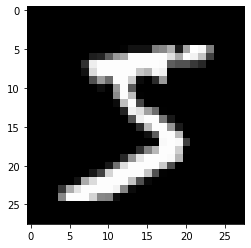

In [5]:
plt.imshow(train_set[0][0].reshape(28, -1), 'gray');

# 2. Creating Discriminator & Generator

In [6]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        number_of_input_neurons = 784    # 28*28 pixels
        number_of_output_neurons = 1    # between 0-1
        
        self.hidden1 = nn.Sequential( 
            nn.Linear(number_of_input_neurons, 1024),
            nn.LeakyReLU(0.2),    # the slope for negative X values in ReLU function
            nn.Dropout(0.3)    # the probability of dropping out neurons
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.output = nn.Sequential(
            torch.nn.Linear(256, number_of_output_neurons),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.output(x)
        return x
    
discriminator = Discriminator()

In [7]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        number_of_input_neurons = 100
        number_of_output_neurons = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(number_of_input_neurons, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.output = nn.Sequential(
            nn.Linear(1024, number_of_output_neurons),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.output(x)
        return x
generator = Generator()

In [8]:
loss = nn.BCELoss()

In [9]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [10]:
def ones_target(size):
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    data = Variable(torch.zeros(size, 1))
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    number_of_data = real_data.size(0)
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(number_of_data) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(number_of_data))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [12]:
def train_generator(optimizer, fake_data):
    number_of_data = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)

    # Calculate error and backpropagate
    error = loss(prediction, ones_target(number_of_data))
    error.backward()

    # Update weights with gradients
    optimizer.step()

    return error

In [13]:
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100))

In [14]:
def create_mini_batch(offset, batch_size):
    tensor_list = []
    
    tensor_size = 0
    for i in range(offset, offset + batch_size):
        try:
            tensor_list.append(torch.from_numpy(train_set[i][0].T))
            tensor_size += 1
        except IndexError:
            break

    tensors = torch.Tensor(tensor_size, 1, 784)
    torch.cat(tensor_list, out=tensors)
    return tensors

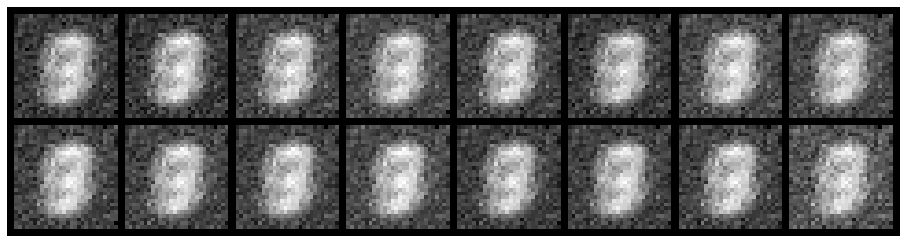

Epoch: [0/10], Batch Num: [0/231]
Discriminator Loss: 1.4328, Generator Loss: 0.6031
D(x): 0.6494, D(G(z)): 0.6190


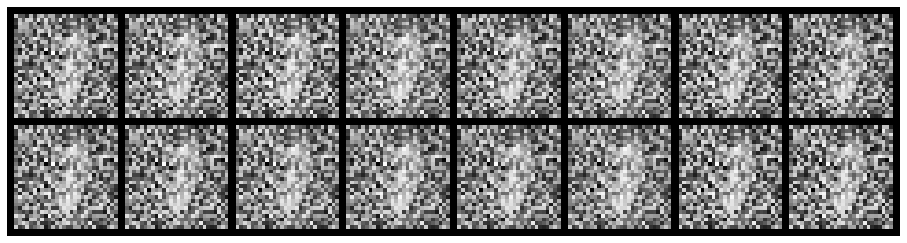

Epoch: [0/10], Batch Num: [100/231]
Discriminator Loss: 1.1874, Generator Loss: 7.1049
D(x): 0.6706, D(G(z)): 0.4216


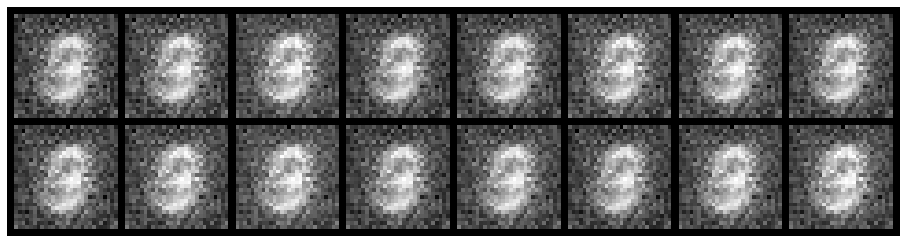

Epoch: [0/10], Batch Num: [200/231]
Discriminator Loss: 1.1810, Generator Loss: 0.9729
D(x): 0.5918, D(G(z)): 0.4641


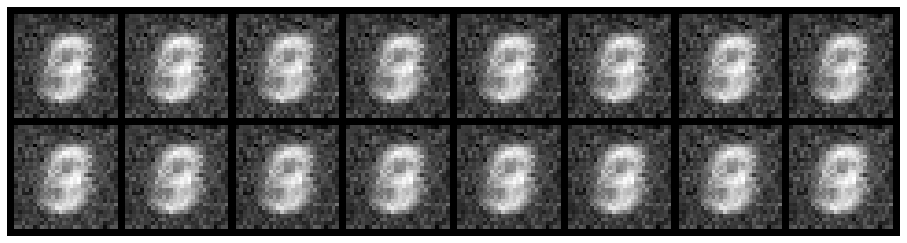

Epoch: [1/10], Batch Num: [0/231]
Discriminator Loss: 0.7974, Generator Loss: 1.4654
D(x): 0.7222, D(G(z)): 0.3668


ValueError: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.

In [17]:
number_of_epochs = 10
batch_size = 256
batch_numbers = int(np.floor(len(train_set) / batch_size)) - 3

logger = Logger(model_name='VGAN', data_name='MNIST')


for epoch in range(number_of_epochs):
    offset = 0
    for batch_number in range(batch_numbers):
        
        # Train Discriminator
        
        real_data = create_mini_batch(offset, batch_size)
        offset += batch_size
        
        fake_data = generator(torch.randn(batch_size, 100)).detach()
        
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        
        # Train Generator
        fake_data = generator(torch.randn(batch_size, 100))
        
        g_error = train_generator(g_optimizer, fake_data)
        
        logger.log(d_error, g_error, epoch, batch_number, batch_numbers)
        
        if batch_number % 100 == 0:
            test_vectors = generator(test_noise)
            test_images = test_vectors.view(test_vectors.size(0), 1, 28, 28)
            
            logger.log_images(
                test_images, num_test_samples, 
                epoch, batch_number, batch_numbers
            );
            
            # Display status Logs
            logger.display_status(
                epoch, number_of_epochs, batch_number, batch_numbers,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        
    
